In [2]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
from math import ceil
import matplotlib.pyplot as plt
import numpy as np

In [3]:
os.listdir('./Osteoporosis/Osteoporosis Knee X-ray/Osteoporosis Knee X-ray')

['normal', 'osteopenia', 'osteoporosis']

In [4]:
dataset_path = './Osteoporosis/Osteoporosis Knee X-ray/Osteoporosis Knee X-ray'

In [5]:
training_transforms = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])

In [6]:
full_dataset = torchvision.datasets.ImageFolder(root = dataset_path, transform = training_transforms)

In [7]:
train_size = int(0.7 * len(full_dataset))
test_size = len(full_dataset) - train_size

print(len(full_dataset), train_size, test_size)

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

239 167 72


In [8]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 32, shuffle=False)

In [9]:
def get_mean_and_std(loader):
    mean = 0
    std = 0
    total_images_count = 0
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_a_batch
    
    mean /= total_images_count
    std /= total_images_count

    return mean, std

In [10]:
mean, std = get_mean_and_std(train_loader)

In [11]:
# Data augmentation

train_transforms = transforms.Compose([
    transforms.Resize((256,256)), # Make sure this is the same size as used for calculating mean and std,
    transforms.RandomHorizontalFlip(), # Randomise direction of image,
    transforms.RandomRotation(25),
    #transforms.ColorJitter(brightness=(0.95, 1.05), contrast=(0.95,1.05)), 
    transforms.ToTensor(), # Multidimensional array,
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

test_transforms = transforms.Compose([
    transforms.Resize((256,256)), # Make sure this is the same size as used for calculating mean and std,
    transforms.ToTensor(), # Multidimensional array,
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [12]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch

    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labels: ', labels)

labels:  tensor([2, 1, 1, 0, 0, 2])


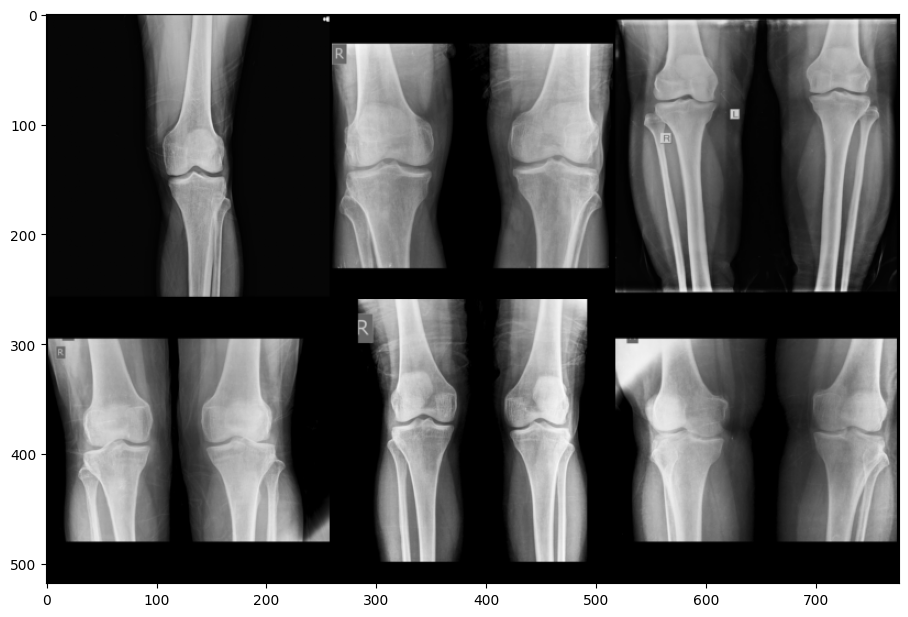

In [13]:
show_transformed_images(train_dataset)

In [14]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 6, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = 6, shuffle=False)

In [15]:
def set_device():
    if torch.cuda.is_available():
        dev = 'cuda:0'
    else:
        dev = 'cpu'
    return torch.device(dev)

In [16]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    device = set_device()

    epoch_acc_list = []
    best_acc = 0

    for epoch in range(n_epochs):
        print(f'Epoch number {epoch + 1}')
        model.train() # Set train mode
        running_loss = 0.0
        running_correct = 0.0
        total = 0

        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            # Reset optimizer parameters to 0
            optimizer.zero_grad()

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels)

            loss.backward() # Back propagate to calculate weight gradient

            optimizer.step() # Update Weights
            
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100.00 * running_correct / total

        print('     - Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f' 
              % (running_correct, total, epoch_acc, epoch_loss))

        test_dataset_acc = evaluate_model_on_test_set(model, test_loader)
    
        epoch_acc_list.append(test_dataset_acc)

        if (test_dataset_acc > best_acc):
            best_acc = test_dataset_acc
            #save_checkpoint(model, epoch, optimizer, best_acc)
        
        cutoff = False
        if cutoff:
            if len(epoch_acc_list) >= 3:
                if epoch_acc_list[-1] == epoch_acc_list[-2] == epoch_acc_list[-3] and epoch_acc_list[-1] > 0:
                    print('Finished')
                    return best_acc, epoch_acc_list
    print('Finished')
    return best_acc, epoch_acc_list

In [17]:
def save_checkpoint(model, epoch, optimizer, best_acc):
    state = {
        'epoch': epoch+1,
        'model': model.state_dict(),
        'best_accuracy': best_acc,
        'optimizer': optimizer.state_dict(),
        'description': 'Efficientnet Optimised Model'
    }

    torch.save(state, 'model_best_checkpoint.pth.tar')

In [18]:
def evaluate_model_on_test_set(model, test_loader):
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0
    device = set_device()

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            predicted_correctly_on_epoch += (predicted == labels).sum().item()
    
    epoch_acc = 100.0* predicted_correctly_on_epoch / total

    print('     - Testing dataset. Got %d out of %d images correctly (%.3f%%)' 
          % (predicted_correctly_on_epoch, total, epoch_acc))
    
    return epoch_acc

In [25]:

efficientnet_model = models.efficientnet_b0(pretrained=False)
#num_ftrs = efficientnet_model.fc.in_features
num_classes = 3
efficientnet_model.fc = nn.Linear(1280, num_classes)
device = set_device()
efficientnet_model = efficientnet_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(efficientnet_model.parameters(), lr=0.00016, momentum=0.3, weight_decay=0.03)
best_acc, epoch_acc_list = train_nn(efficientnet_model, train_loader, test_loader, criterion, optimizer, 20)


Epoch number 1
     - Training dataset. Got 0 out of 167 images correctly (0.000%). Epoch loss: 6.814
     - Testing dataset. Got 0 out of 72 images correctly (0.000%)
Epoch number 2
     - Training dataset. Got 14 out of 167 images correctly (8.383%). Epoch loss: 6.668
     - Testing dataset. Got 0 out of 72 images correctly (0.000%)
Epoch number 3
     - Training dataset. Got 55 out of 167 images correctly (32.934%). Epoch loss: 6.506
     - Testing dataset. Got 0 out of 72 images correctly (0.000%)
Epoch number 4
     - Training dataset. Got 73 out of 167 images correctly (43.713%). Epoch loss: 6.376
     - Testing dataset. Got 21 out of 72 images correctly (29.167%)
Epoch number 5
     - Training dataset. Got 88 out of 167 images correctly (52.695%). Epoch loss: 6.246
     - Testing dataset. Got 30 out of 72 images correctly (41.667%)
Epoch number 6
     - Training dataset. Got 86 out of 167 images correctly (51.497%). Epoch loss: 6.143
     - Testing dataset. Got 32 out of 72 imag

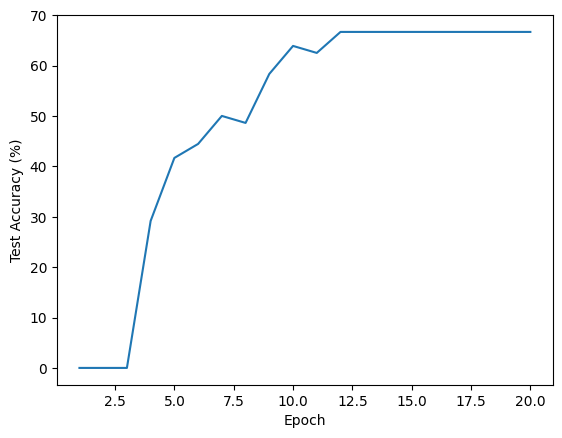

Best Accuracy: 66.667%


In [26]:
plt.plot(list(range(1,len(epoch_acc_list)+1)), epoch_acc_list)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.show()

print('Best Accuracy: %.3f%%' %(best_acc))